Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB

First 5 Rows:
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   

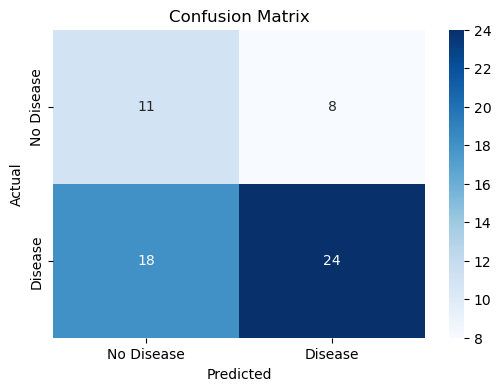

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
df = pd.read_csv('heart_disease.csv')

# Display basic info
print("Dataset Info:")
df.info()
print("\nFirst 5 Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Handle missing values
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=['number']).columns] = imputer.fit_transform(df.select_dtypes(include=['number']))

# Drop duplicates if any
df.drop_duplicates(inplace=True)

# Strip column names of any extra spaces
df.columns = df.columns.str.strip()

# Explicitly check if 'Heart Disease' column exists
if 'Heart Disease' in df.columns:
    target_col = 'Heart Disease'
else:
    # Automatically detect the target column (assumes it's binary: 0/1 or Yes/No)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    if not binary_cols:
        raise ValueError("No binary target column found in the dataset.")
    target_col = binary_cols[0]  # Selecting the first binary column found

print(f"Detected target column: {target_col}")

# Convert target column to numerical if necessary
df[target_col] = df[target_col].astype(int)

# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
numerical_cols.remove(target_col)  # Ensure target is not included in features

# Encode categorical variables if necessary
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Split features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling only on numerical columns
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Train Logistic Regression model with class balancing
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"\nModel Performance:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}\nROC-AUC: {roc_auc:.4f}")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
